In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-851373fd-22ab-c2b1-929f-cb321462095b)


## Download and Exploring the dataset

We can download from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed_rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
ls: cannot access 'pubmed_rct': No such file or directory


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [6]:
# Function to read the lines of text file

def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")

In [8]:
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

In [10]:
# Function to convert the text file into a list of dictionaries
def preprocess_text_with_line_numbers(filename):
  with open(filename, "r") as f:
    input_lines = f.readlines()
  list_dict = []
  for i in input_lines:
    if i.startswith("###"):
      id = i[:-1]
    elif i.isspace():
      pass
    else:
      line = i.split("\t")
      list_dict.append({"id":id,"target":line[0],"text":line[1]})
  return list_dict

In [11]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [12]:
# To convert into Dataframe for better visualization
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,id,target,text
0,###24293578,OBJECTIVE,To investigate the efficacy of @ weeks of dail...
1,###24293578,METHODS,A total of @ patients with primary knee OA wer...
2,###24293578,METHODS,Outcome measures included pain reduction and i...
3,###24293578,METHODS,Pain was assessed using the visual analog pain...
4,###24293578,METHODS,Secondary outcome measures included the Wester...


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [14]:
# Get lists of sentences
train_sentences = train_df.text.tolist() 
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# Make numeric labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())

val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
# One hot encode for labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Model 0: TF-IDF Multinomial Naive Bayes classifier

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()
Train_vect = vect.fit_transform(train_sentences)
val_vect = vect.transform(val_sentences)
test_vect = vect.transform(test_sentences)
vect.get_feature_names_out()
model0 = MultinomialNB()
model0.fit(X=Train_vect,
        y=train_labels_encoded)

# Evaluate the model on validation dataset
model0.score(X=val_vect,
          y=val_labels_encoded)

0.7218323844829869

In [123]:
# Prediction on test data
from sklearn.metrics import classification_report

model0_pred = model0.predict(test_vect)
baseline_results = classification_report(test_labels_encoded, model0_pred)
print(baseline_results)


              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3621
           1       0.63      0.58      0.60      4571
           2       0.72      0.88      0.79      9897
           3       0.74      0.13      0.22      2333
           4       0.76      0.85      0.80      9713

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135



## Preprocessing for deep sequence models

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

### Vectorization

In [21]:
#average number of words for each sentences
train_length = [len(sentence.split()) for sentence in train_sentences]
train_avg_length = np.mean(train_length)
train_avg_length

26.338269273494777

In [22]:
# Use NumPy's percentile to find the value which covers 95% of the sentence lengths.
train_95_percentile_length = np.percentile(train_length, 95)
train_95_percentile_length

55.0

It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

In [23]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=68000, output_sequence_length=55)

In [24]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [25]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
Although diabetic retinopathy is not a perfect proxy for diabetes-related brain and cognitive decline , patients with type @ diabetes and retinopathy represent a subgroup at higher risk for future cognitive decline .


Length of text: 33

Vectorized text:
[[ 311 1062 3007   20   31    8 7036 9594   11 7718  623    3  301 1078
    12    7  248  223    3 3007 2613    8  853   15   82   73   11  652
   301 1078    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [26]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [27]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [28]:
# Create token embedding layer

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), #length of vocab
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

#Testing of our embedding layer
print(f"Sentence before vectorization:\n{target_sentence}\n")
target_sentence_vect = text_vectorizer(target_sentence)
print(f"Sentence after vectorization:\n{target_sentence_vect}\n")
target_sentence_embed = token_embed(target_sentence_vect)
print(f"Sentence after token embedding:\n{target_sentence_embed}\n")
print(f"Shape of sentence after token embedding\n{target_sentence_embed.shape}")


Sentence before vectorization:
Although diabetic retinopathy is not a perfect proxy for diabetes-related brain and cognitive decline , patients with type @ diabetes and retinopathy represent a subgroup at higher risk for future cognitive decline .


Sentence after vectorization:
[ 311 1062 3007   20   31    8 7036 9594   11 7718  623    3  301 1078
   12    7  248  223    3 3007 2613    8  853   15   82   73   11  652
  301 1078    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]

Sentence after token embedding:
[[ 0.01112211 -0.04863603 -0.00056188 ...  0.03764847  0.02032058
   0.01225076]
 [-0.03404076 -0.03374093  0.03472347 ... -0.00605466 -0.00933989
  -0.0017329 ]
 [-0.02436437 -0.00244552  0.00940365 ... -0.04115814 -0.04709912
  -0.01886784]
 ...
 [-0.0135036  -0.04681354  0.02156377 ...  0.01523693 -0.01409222
  -0.04122778]
 [-0.0135036  -0.04681354  0.02156377 ...  0.01523693 -0.01409222
  -0.0412277

### Create datasets (as fast as possible)

In [29]:
## Transform datasets into tensorflow datasets(PrefetchDataset of batches)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [30]:
# Transform thr TensorSliceDataset into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [31]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with Token Embeddings

In [32]:
from tensorflow.python.eager.monitoring import Metric
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

#Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [33]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [34]:
#Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9109 - accuracy: 0.6408 - val_loss: 0.6764 - val_accuracy: 0.7410
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6527 - accuracy: 0.7582 - val_loss: 0.6249 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6137 - accuracy: 0.7768 - val_loss: 0.5932 - val_accuracy: 0.7822


In [35]:
#Evaluate on the whole validation dataset
model_1.evaluate(val_dataset)


945/945 [==============================] - 3s 3ms/step - loss: 0.5950 - accuracy: 0.7858


[0.5950444936752319, 0.785813570022583]

In [36]:
from tensorflow.python.ops.math_ops import arg_max
# Make prediction
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.5421499e-01, 1.4976756e-01, 8.5868545e-02, 2.8380087e-01,
        2.6347976e-02],
       [4.3033633e-01, 2.6542082e-01, 1.4107825e-02, 2.8190917e-01,
        8.2259029e-03],
       [1.2765399e-01, 6.2592048e-03, 1.2730671e-03, 8.6477590e-01,
        3.7797203e-05],
       ...,
       [5.6788449e-06, 5.0955091e-04, 6.5467512e-04, 3.0950405e-06,
        9.9882704e-01],
       [6.0315497e-02, 4.8263270e-01, 9.3331754e-02, 6.9243520e-02,
        2.9447657e-01],
       [1.5070568e-01, 7.2033387e-01, 3.9040513e-02, 3.2604128e-02,
        5.7315752e-02]], dtype=float32)

In [37]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1) 
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [125]:
#Calculate result

model_1_results = classification_report(val_labels_encoded, model_1_preds)
print(model_1_results)

              precision    recall  f1-score   support

           0       0.63      0.51      0.57      3449
           1       0.68      0.72      0.70      4582
           2       0.86      0.88      0.87      9964
           3       0.60      0.59      0.59      2376
           4       0.85      0.87      0.86      9841

    accuracy                           0.79     30212
   macro avg       0.72      0.71      0.72     30212
weighted avg       0.78      0.79      0.78     30212



## Model 2: Feature extraction with pretrained token embeddings
**Universal Sentence Encoder**

In [39]:
# Download pretrained TensorFlow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [40]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
The third menstrual cycles is control cycle after milk-taking .


Sentence after embedding:
[ 0.04091635 -0.03937635  0.06240831  0.00135208 -0.05015229 -0.07263879
  0.05168417 -0.04510321  0.02919217  0.05978332  0.01355815 -0.08333166
  0.04681141  0.07071228 -0.0197872   0.05301743 -0.07931982 -0.04674127
  0.03145483  0.05055732 -0.07832294  0.08094781 -0.01812909  0.02301667
  0.05610493  0.02016207 -0.02690014  0.05217644 -0.018191    0.06606384] (truncated output)...

Length of sentence embedding:
512


In [41]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

#compile
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [42]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [43]:
# fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9186 - accuracy: 0.6479 - val_loss: 0.7995 - val_accuracy: 0.6835
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7763 - accuracy: 0.6971 - val_loss: 0.7575 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7607 - accuracy: 0.7092 - val_loss: 0.7442 - val_accuracy: 0.7048


In [44]:
#Evaluate the model on the whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7502 - accuracy: 0.7089


[0.7502020597457886, 0.7088904976844788]

In [45]:
# Prediction
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 10ms/step


array([[3.9022589e-01, 3.9073175e-01, 3.7189899e-03, 1.9778255e-01,
        1.7540885e-02],
       [3.1575260e-01, 5.0015426e-01, 4.5057414e-03, 1.7411649e-01,
        5.4708119e-03],
       [2.3737352e-01, 1.6518803e-01, 2.4027022e-02, 5.3820157e-01,
        3.5209849e-02],
       ...,
       [8.4790390e-04, 3.8377412e-03, 4.4702649e-02, 5.3372461e-04,
        9.5007795e-01],
       [4.7323992e-03, 5.7889938e-02, 2.5581154e-01, 1.6539947e-03,
        6.7991209e-01],
       [1.5393382e-01, 1.9217028e-01, 5.8943802e-01, 6.0158921e-03,
        5.8442023e-02]], dtype=float32)

In [46]:
model_2_pred = tf.argmax(model_2_pred_probs, axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [128]:
model_2_results = classification_report(val_labels_encoded,model_2_pred)
print(model_2_results)

              precision    recall  f1-score   support

           0       0.61      0.40      0.49      3449
           1       0.56      0.67      0.61      4582
           2       0.79      0.78      0.79      9964
           3       0.51      0.56      0.54      2376
           4       0.78      0.80      0.79      9841

    accuracy                           0.71     30212
   macro avg       0.65      0.64      0.64     30212
weighted avg       0.71      0.71      0.71     30212



## Model 3: Conv1D with character embeddings

### Character-level tokenizer

In [48]:
# function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))
split_chars(random_training_sentence)

'T h e   t h i r d   m e n s t r u a l   c y c l e s   i s   c o n t r o l   c y c l e   a f t e r   m i l k - t a k i n g   . \n'

In [49]:
#Split train, validation and test sentences

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n'

In [50]:
# What's the average character length?

train_chars_length = [len(sentence) for sentence in train_sentences]
train_chars_length_mean = np.mean(train_chars_length)
train_chars_length_mean

150.3662574983337

In [51]:
# What us the character length for 95 percentile?
train_chars_length_95_percentile = np.percentile(train_chars_length, 95)
train_chars_length_95_percentile

291.0

In [52]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [53]:
len(alphabet)

68

In [54]:
from numpy.lib.function_base import vectorize
char_vectorizer = TextVectorization(max_tokens=len(alphabet) + 2,
                                    standardize="lower_and_strip_punctuation",
                                    output_sequence_length=int(train_chars_length_95_percentile),
                                    name="char_vectorizer")

In [55]:
char_vectorizer.adapt(train_chars)

In [56]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [57]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
R e g r e s s i o n   a n a l y s i s   a d j u s t i n g   p o s t - t r e a t m e n t   v a l u e s   o f   n u t r i t i o n   m a r k e r s   f o r   b a s e l i n e   v a l u e s   ,   o m e g a - @   t r e a t m e n t   ,   a n d   p a t i e n t s   '   b a s e l i n e   d e m o g r a p h i c   a n d   c l i n i c a l   d a t a   r e v e a l e d   t h a t   o m e g a - @   t r e a t m e n t   w a s   a   s i g n i f i c a n t   i n d e p e n d e n t   p r e d i c t o r   o f   i n c r e a s e d   s e r u m   p r e a l b u m i n   l e v e l   (   @   ;   @   %   c o n f i d e n c e   i n t e r v a l   @   ,   @   ;   P   =   @   )   . 


Length of chars: 272

Vectorized chars:
[[ 8  2 18  8  2  9  9  4  7  6  5  6  5 12 19  9  4  9  5 10 27 16  9  3
   4  6 18 14  7  9  3  3  8  2  5  3 15  2  6  3 21  5 12 16  2  9  7 17
   6 16  3  8  4  3  4  7  6 15  5  8 23  2  8  9 17  7  8 22  5  9  2 12
   4  6  2 21  5 12 16  2  9  7 15  2 18  5  3  8  2  5  3 15  2  6  3 

### Character-level embedding

In [58]:
char_embed = layers.Embedding(input_dim = len(alphabet)+2,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

#testing our characters embdding layer
print(f"sentence before vectorization:\n{random_train_chars}\n")
sentence_vector = char_vectorizer(random_train_chars)
print(f"after vectorization:\n{sentence_vector}\n")
sentence_embed = char_embed(sentence_vector)
print(f"after embedding:\n{sentence_embed}")
print(f"shape: {sentence_embed.shape}")

sentence before vectorization:
R e g r e s s i o n   a n a l y s i s   a d j u s t i n g   p o s t - t r e a t m e n t   v a l u e s   o f   n u t r i t i o n   m a r k e r s   f o r   b a s e l i n e   v a l u e s   ,   o m e g a - @   t r e a t m e n t   ,   a n d   p a t i e n t s   '   b a s e l i n e   d e m o g r a p h i c   a n d   c l i n i c a l   d a t a   r e v e a l e d   t h a t   o m e g a - @   t r e a t m e n t   w a s   a   s i g n i f i c a n t   i n d e p e n d e n t   p r e d i c t o r   o f   i n c r e a s e d   s e r u m   p r e a l b u m i n   l e v e l   (   @   ;   @   %   c o n f i d e n c e   i n t e r v a l   @   ,   @   ;   P   =   @   )   . 


after vectorization:
[ 8  2 18  8  2  9  9  4  7  6  5  6  5 12 19  9  4  9  5 10 27 16  9  3
  4  6 18 14  7  9  3  3  8  2  5  3 15  2  6  3 21  5 12 16  2  9  7 17
  6 16  3  8  4  3  4  7  6 15  5  8 23  2  8  9 17  7  8 22  5  9  2 12
  4  6  2 21  5 12 16  2  9  7 15  2 18  5  3  8  2  5  3 15  2  6  3  5
  6 1

### Conv1D model to fit on character embeddings

In [59]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
chars_vectors = char_vectorizer(inputs)
chars_embeddings = char_embed(chars_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(chars_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)

#compile
model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])


In [60]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 291)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 291, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 291, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

### char-level batched `PrefetchedDataset`'s

In [61]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [62]:
#fit
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2616 - accuracy: 0.4890 - val_loss: 1.0300 - val_accuracy: 0.5838
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0028 - accuracy: 0.5968 - val_loss: 0.9292 - val_accuracy: 0.6326
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9302 - accuracy: 0.6351 - val_loss: 0.8681 - val_accuracy: 0.6602


In [63]:
# Evaluate the whole validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8913 - accuracy: 0.6554


[0.8912546038627625, 0.6554018259048462]

In [64]:
# Make predictions with character model only
model_3_pred_probs =  model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[0.18154016, 0.27087602, 0.08709509, 0.4367282 , 0.02376061],
       [0.17802913, 0.66752505, 0.03160692, 0.06762186, 0.05521702],
       [0.18883507, 0.19405368, 0.27146223, 0.25815517, 0.08749386],
       ...,
       [0.02474005, 0.03192232, 0.37688166, 0.07179865, 0.49465728],
       [0.01237892, 0.05130149, 0.2290328 , 0.0149211 , 0.6923657 ],
       [0.689748  , 0.20047349, 0.05157284, 0.05446254, 0.00374307]],
      dtype=float32)

In [65]:
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 2, ..., 4, 4, 0])>

In [126]:
model_3_results = classification_report(val_labels_encoded,model_3_pred)
print(model_3_results)

              precision    recall  f1-score   support

           0       0.51      0.26      0.34      3449
           1       0.48      0.53      0.50      4582
           2       0.70      0.84      0.76      9964
           3       0.43      0.47      0.45      2376
           4       0.79      0.71      0.75      9841

    accuracy                           0.66     30212
   macro avg       0.58      0.56      0.56     30212
weighted avg       0.65      0.66      0.65     30212



## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [67]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [68]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 291)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

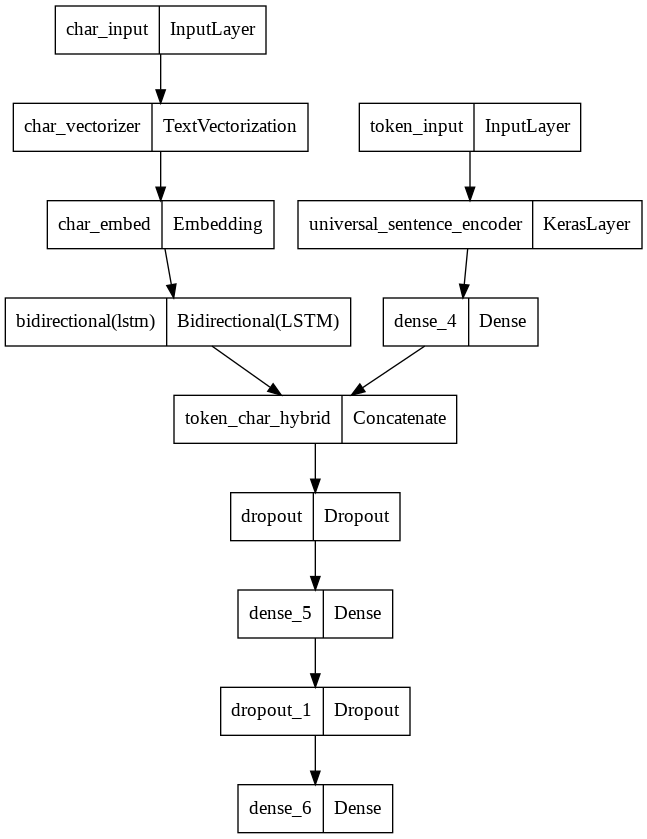

In [69]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [70]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [71]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [73]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 35ms/step - loss: 0.9686 - accuracy: 0.6168 - val_loss: 0.7884 - val_accuracy: 0.6941
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.7967 - accuracy: 0.6917 - val_loss: 0.7148 - val_accuracy: 0.7241
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7713 - accuracy: 0.7050 - val_loss: 0.6925 - val_accuracy: 0.7347


In [74]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.6982 - accuracy: 0.7347


[0.6982237100601196, 0.7347411513328552]

In [75]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 27s 26ms/step


array([[4.2604893e-01, 3.7403917e-01, 4.1246181e-03, 1.8442760e-01,
        1.1359620e-02],
       [3.3743113e-01, 4.2981756e-01, 3.9377701e-03, 2.2603521e-01,
        2.7783320e-03],
       [2.8617913e-01, 1.5868810e-01, 5.2933510e-02, 4.6584424e-01,
        3.6355026e-02],
       ...,
       [1.5937680e-04, 3.5413604e-03, 3.1482071e-02, 4.9807008e-05,
        9.6476740e-01],
       [6.0755801e-03, 4.6277236e-02, 2.2323097e-01, 3.0029588e-03,
        7.2141325e-01],
       [3.7015995e-01, 2.5321487e-01, 2.5742078e-01, 4.7804136e-02,
        7.1400248e-02]], dtype=float32)

In [76]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [77]:
# Get results of token-char-hybrid model
model_4_results = classification_report(val_labels_encoded,model_4_preds)
print(model_4_results)

              precision    recall  f1-score   support

           0       0.60      0.45      0.52      3449
           1       0.57      0.70      0.63      4582
           2       0.81      0.82      0.81      9964
           3       0.64      0.57      0.60      2376
           4       0.81      0.80      0.81      9841

    accuracy                           0.73     30212
   macro avg       0.69      0.67      0.67     30212
weighted avg       0.74      0.73      0.73     30212



## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [78]:
train_df.head()

,id,target,text
0,###24293578,OBJECTIVE,To investigate the efficacy of @ weeks of dail...
1,###24293578,METHODS,A total of @ patients with primary knee OA wer...
2,###24293578,METHODS,Outcome measures included pain reduction and i...
3,###24293578,METHODS,Pain was assessed using the visual analog pain...
4,###24293578,METHODS,Secondary outcome measures included the Wester...


In [79]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [80]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 425 ms, sys: 93.2 ms, total: 518 ms
Wall time: 519 ms


(180040, 30212, 30135)

In [81]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Positional embedding

In [82]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [83]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [84]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [85]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [86]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [87]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [88]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [89]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 291)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

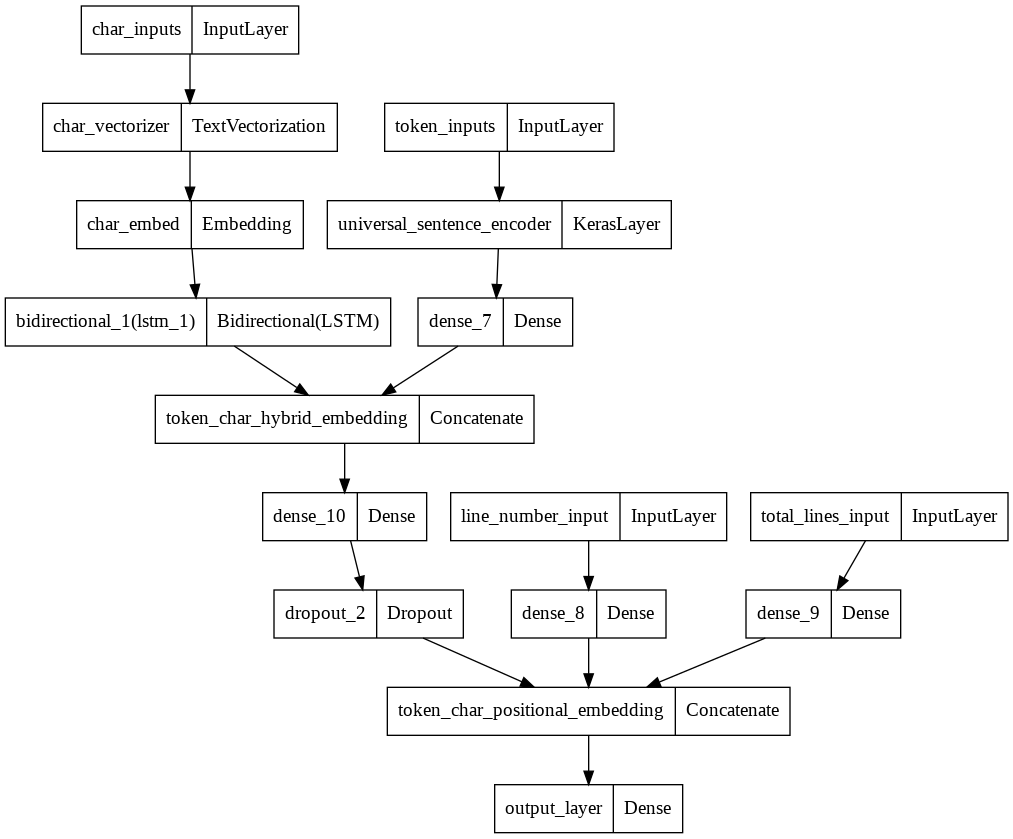

In [90]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [91]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [92]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [93]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 41ms/step - loss: 1.1008 - accuracy: 0.7180 - val_loss: 0.9854 - val_accuracy: 0.7982
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9675 - accuracy: 0.8143 - val_loss: 0.9513 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9521 - accuracy: 0.8214 - val_loss: 0.9397 - val_accuracy: 0.8281


In [94]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 22ms/step


array([[0.5081661 , 0.10126835, 0.01253099, 0.35983583, 0.01819875],
       [0.48976862, 0.0854681 , 0.03722428, 0.37698978, 0.01054923],
       [0.32326758, 0.09324224, 0.12616202, 0.3909755 , 0.06635256],
       ...,
       [0.03432335, 0.09250452, 0.03975095, 0.02957139, 0.80384976],
       [0.0336465 , 0.349438  , 0.0865702 , 0.02482222, 0.505523  ],
       [0.2078286 , 0.59428394, 0.10086522, 0.03785548, 0.05916676]],
      dtype=float32)

In [95]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [96]:
# Calculate results of token-char-positional hybrid model
model_5_results = classification_report(val_labels_encoded, model_5_preds)
print(model_5_results)


              precision    recall  f1-score   support

           0       0.70      0.76      0.73      3449
           1       0.82      0.84      0.83      4582
           2       0.88      0.87      0.88      9964
           3       0.72      0.58      0.64      2376
           4       0.86      0.87      0.86      9841

    accuracy                           0.83     30212
   macro avg       0.80      0.79      0.79     30212
weighted avg       0.83      0.83      0.83     30212



## Model 6: Transfer Learning with pretrained token embeddings + positional embeddings

In [116]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
z = layers.Dropout(0.5)(token_embeddings)
token_outputs = layers.Dense(128, activation="relu")(z)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 3. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
#combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              #char_model.output])


# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_positional_embedding")([line_number_model.output,
                                                          total_line_model.output,
                                                          token_model.output])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input],
                         outputs=output_layer)

In [117]:
# Get a summary of our token, char and positional embedding model
model_6.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']           
 rasLayer)                                                                                        
                                                                                                  
 line_number_input (InputLayer)  [(None, 15)]        0           []                               
                                                                                                  
 total_lines_input (InputLayer)  [(None, 20)]        0           []                        

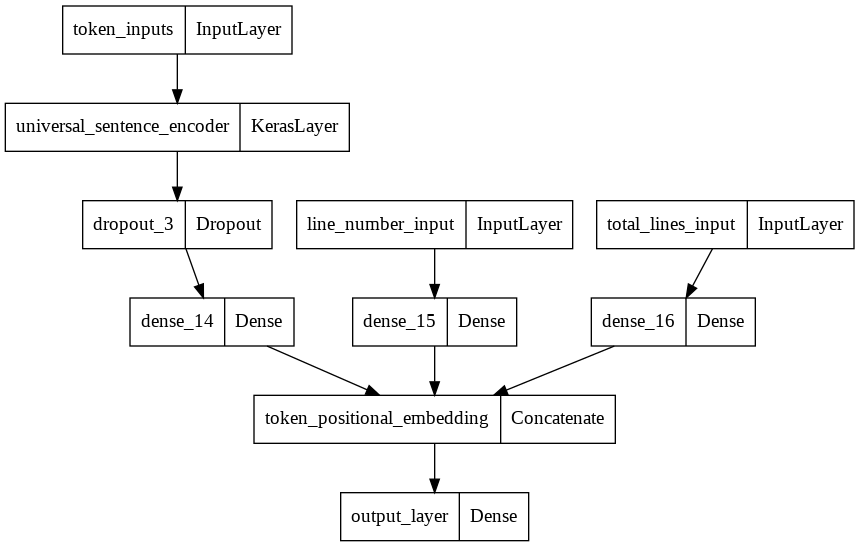

In [118]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_6)

In [119]:
# Compile token, char, positional embedding model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [120]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences)) # train tokens
                                                                
train_pos_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_token_dataset = tf.data.Dataset.zip((train_pos_token_data, train_pos_token_labels)) # combine data and labels
train_pos_token_dataset = train_pos_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences))

val_pos_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_token_dataset = tf.data.Dataset.zip((val_pos_token_data, val_pos_token_labels))
val_pos_token_dataset = val_pos_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_token_dataset, val_pos_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [121]:
# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_pos_token_dataset,
                              steps_per_epoch=int(0.1*len(train_pos_token_dataset)),
                              epochs=3,
                              validation_data= val_pos_token_dataset,
                              validation_steps=int(0.1*len(val_pos_token_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 17ms/step - loss: 1.1448 - accuracy: 0.6925 - val_loss: 1.0024 - val_accuracy: 0.7852
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 1.0129 - accuracy: 0.7770 - val_loss: 0.9796 - val_accuracy: 0.8022
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.9973 - accuracy: 0.7864 - val_loss: 0.9727 - val_accuracy: 0.8068


In [130]:
# Make predictions with token-char-positional hybrid model
model_6_pred_probs = model_6.predict(val_pos_token_dataset, verbose=1)
model_6_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.44506457, 0.107184  , 0.01218204, 0.39660305, 0.03896634],
       [0.43506458, 0.12943313, 0.03848334, 0.38176653, 0.01525242],
       [0.24899834, 0.16335438, 0.16022532, 0.35148802, 0.07593392],
       ...,
       [0.02803793, 0.10222077, 0.05284798, 0.02562116, 0.79127216],
       [0.02951318, 0.3732547 , 0.08797574, 0.0204914 , 0.488765  ],
       [0.25865832, 0.3465411 , 0.2188289 , 0.04002304, 0.13594857]],
      dtype=float32)

In [131]:
# Turn prediction probabilities into prediction classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [132]:
# Calculate results of token-char-positional hybrid model
model_6_results = classification_report(val_labels_encoded, model_6_preds)
print(model_6_results)


              precision    recall  f1-score   support

           0       0.72      0.60      0.65      3449
           1       0.82      0.81      0.81      4582
           2       0.85      0.85      0.85      9964
           3       0.62      0.64      0.63      2376
           4       0.83      0.88      0.85      9841

    accuracy                           0.81     30212
   macro avg       0.77      0.76      0.76     30212
weighted avg       0.81      0.81      0.81     30212



## Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "hybrid_pos_token_embed": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

## Evaluate model on test dataset

In [147]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [148]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 21s 22ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [149]:
# Evaluate loaded model test predictions
loaded_model_test_results = classification_report(y_true=test_labels_encoded,
                                              y_pred=test_preds)
print(loaded_model_test_results)

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      3621
           1       0.81      0.85      0.83      4571
           2       0.87      0.87      0.87      9897
           3       0.71      0.59      0.64      2333
           4       0.85      0.86      0.86      9713

    accuracy                           0.83     30135
   macro avg       0.79      0.78      0.79     30135
weighted avg       0.83      0.83      0.83     30135



## Find most wrong

In [150]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 12.4 s, sys: 1.15 s, total: 13.5 s
Wall time: 11.9 s


['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RES

In [151]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.456312,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.320365,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.768893,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.756946,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.675552,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.870697,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.559811,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.526258,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.466872,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.584678,True


In [152]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.944653,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.930780,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.926349,False
28602,CONCLUSIONS,www.chictr.org registration chictr-trc-@ .,13,13,BACKGROUND,0.920044,False
16633,CONCLUSIONS,clinicaltrials.gov identifier : nct@ .,19,19,BACKGROUND,0.919119,False
...,...,...,...,...,...,...,...
2219,CONCLUSIONS,among men and women with moderately elevated b...,7,8,RESULTS,0.832476,False
24605,CONCLUSIONS,clinicaltrials.gov identifier nct@ .,10,10,BACKGROUND,0.832299,False
26098,CONCLUSIONS,clinicaltrials.gov identifier nct@ .,10,10,BACKGROUND,0.832299,False
18789,BACKGROUND,these programs were evaluated in a head-to-hea...,3,12,METHODS,0.832236,False


In [153]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9446528553962708, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9307804107666016, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9263492226600647, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9200437068939209, Line number: 13, Total lines: 13

Text:
www.chictr.org registration chictr-trc-@ .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9191185832023621, Line number: 19, Total lines: 19

Text:
clinicaltrials.gov identifier : nct@ .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9182265996932983, Line number: 1, Total lines: 11

Text:
pretest-posttest .

---